一開始這兩個必須要裝 因為fastai裡由我們要的東西

In [ ]:
import os
import glob
import time
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb

import torch
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_colab = None

In [ ]:
!pip install fastai --upgrade

Requirement already up-to-date: fastai in /usr/local/lib/python3.6/dist-packages (2.1.7)


這個是我們train和val的存放地址，在這裡把它找到然後分成了train和val


In [ ]:
####

# if use_colab == True:
#     path = coco_path
# else:
path = "/content/drive/MyDrive/finalproject/flower"
    
paths = glob.glob(path + "/*.jpg") # Grabbing all the image file names
print(paths)
np.random.seed(123)
paths_subset = np.random.choice(paths, 500, replace=False) # choosing 1000 images randomly
rand_idxs = np.random.permutation(500)
train_idxs = rand_idxs[:450] # choosing the first 8000 as training set
val_idxs = rand_idxs[450:] # choosing last 2000 as validation set
train_paths = paths_subset[train_idxs]
val_paths = paths_subset[val_idxs]
print(len(train_paths), len(val_paths))

['/content/drive/MyDrive/finalproject/flower/c1.staticflickr.com-1-691-33322064511_5aafb9e5c1.jpg', '/content/drive/MyDrive/finalproject/flower/c1.staticflickr.com-1-687-32970418770_83f813194d.jpg', '/content/drive/MyDrive/finalproject/flower/c1.staticflickr.com-3-2858-33555373011_04dbc071e9.jpg', '/content/drive/MyDrive/finalproject/flower/c1.staticflickr.com-3-2507-32057568444_f5df57acc7.jpg', '/content/drive/MyDrive/finalproject/flower/c1.staticflickr.com-3-2814-33506495091_fe513eeefa.jpg', '/content/drive/MyDrive/finalproject/flower/c1.staticflickr.com-1-762-33238024811_3c3668bcb8.jpg', '/content/drive/MyDrive/finalproject/flower/c1.staticflickr.com-1-690-33141719576_64de3bb8a6.jpg', '/content/drive/MyDrive/finalproject/flower/c1.staticflickr.com-3-2305-32098317303_c1a7c5cc46.jpg', '/content/drive/MyDrive/finalproject/flower/c1.staticflickr.com-3-2852-33248530115_e39b59847d.jpg', '/content/drive/MyDrive/finalproject/flower/c1.staticflickr.com-1-726-31479153103_55347d29c5.jpg', '/co

簡單print 沒什麼意義可以刪掉

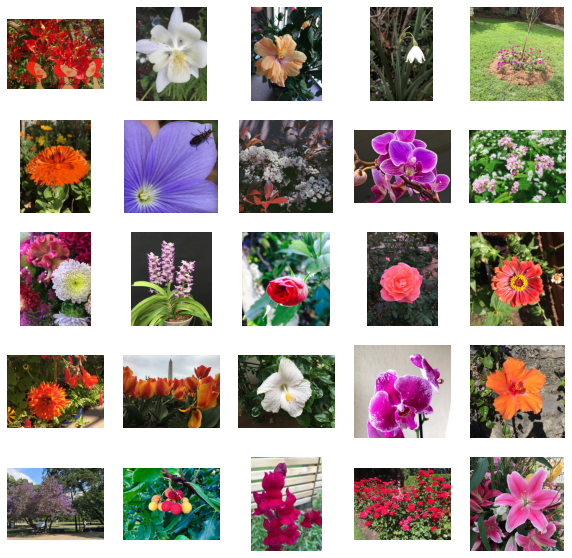

In [ ]:
_, axes = plt.subplots(5, 5, figsize=(10, 10))
for ax, img_path in zip(axes.flatten(), train_paths):
    ax.imshow(Image.open(img_path))
    ax.axis("off")

picture resize和換成lab form

In [ ]:
###

SIZE = 256
class ColorizationDataset(Dataset):
    def __init__(self, paths, split='train'):
        if split == 'train':
            self.transforms = transforms.Compose([
                transforms.Resize((SIZE, SIZE),  Image.BICUBIC),
                transforms.RandomHorizontalFlip(), # A little data augmentation!
            ])
        elif split == 'val':
            self.transforms = transforms.Resize((SIZE, SIZE),  Image.BICUBIC)
        elif split == 'test':
            self.transforms = transforms.Resize((SIZE, SIZE),  Image.BICUBIC)
            
        self.split = split
        self.size = SIZE
        self.paths = paths
    
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        img = self.transforms(img)
        img = np.array(img)
        img_lab = rgb2lab(img).astype("float32") # Converting RGB to L*a*b
        img_lab = transforms.ToTensor()(img_lab)
        L = img_lab[[0], ...] / 50. - 1. # Between -1 and 1
        ab = img_lab[[1, 2], ...] / 110. # Between -1 and 1
        
        return {'L': L, 'ab': ab}
    
    def __len__(self):
        return len(self.paths)

def make_dataloaders(batch_size=10, n_workers=4, pin_memory=True, **kwargs): # A handy function to make our dataloaders
    dataset = ColorizationDataset(**kwargs)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=n_workers,
                            pin_memory=pin_memory)
    return dataloader

換train和val

In [ ]:
###

train_dl = make_dataloaders(paths=train_paths, split='train')
val_dl = make_dataloaders(paths=val_paths, split='val')

data = next(iter(train_dl))
Ls, abs_ = data['L'], data['ab']
print(Ls.shape, abs_.shape)
print(len(train_dl), len(val_dl))

torch.Size([10, 1, 256, 256]) torch.Size([10, 2, 256, 256])
45 5


In [ ]:
data = next(iter(val_dl))
Ls, abs_ = data['L'], data['ab']
print(Ls.shape, abs_.shape)
print(len(val_dl))

torch.Size([10, 1, 256, 256]) torch.Size([10, 2, 256, 256])
5


In [ ]:
###

test_path = "/content/drive/MyDrive/test_4471"
test_paths = glob.glob(test_path + "/*.jpg") # Grabbing all the image file names
print(test_paths)
np.random.seed(123)
test_paths_subset = np.random.choice(test_paths, 3, replace=False)
rand_idxs = np.random.permutation(3)
test_idxs = rand_idxs[:3]
TEST_paths = test_paths_subset[test_idxs]
print(len(TEST_paths))

test_dl = make_dataloaders(paths=TEST_paths, split='test')
data = next(iter(test_dl))
Ls, abs_ = data['L'], data['ab']
print(Ls.shape, abs_.shape)
print(len(test_dl))


['/content/drive/MyDrive/test_4471/c1.staticflickr.com-9-8632-28671334121_abf87dea08.jpg', '/content/drive/MyDrive/test_4471/c1.staticflickr.com-9-8542-28488716692_4949f04f7a.jpg', '/content/drive/MyDrive/test_4471/c1.staticflickr.com-9-8212-28671336121_2988f51003.jpg', '/content/drive/MyDrive/test_4471/c1.staticflickr.com-9-8852-28671335211_0139f2ee74.jpg']
3
torch.Size([3, 1, 256, 256]) torch.Size([3, 2, 256, 256])
1


unet block的definition
discriminator的definition（patchGAN，和我們舊的discriminator完全一樣的）

In [ ]:
###


class UnetBlock(nn.Module):
    def __init__(self, nf, ni, submodule=None, input_c=None, dropout=False,
                 innermost=False, outermost=False):
        super().__init__()
        self.outermost = outermost
        if input_c is None: input_c = nf
        downconv = nn.Conv2d(input_c, ni, kernel_size=4,
                             stride=2, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = nn.BatchNorm2d(ni)
        uprelu = nn.ReLU(True)
        upnorm = nn.BatchNorm2d(nf)
        
        if outermost:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(ni, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]
            if dropout: up += [nn.Dropout(0.5)]
            model = down + [submodule] + up
        self.model = nn.Sequential(*model)
    
    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], 1)

class Unet(nn.Module):
    def __init__(self, input_c=1, output_c=2, n_down=8, num_filters=64):
        super().__init__()
        unet_block = UnetBlock(num_filters * 8, num_filters * 8, innermost=True)
        for _ in range(n_down - 5):
            unet_block = UnetBlock(num_filters * 8, num_filters * 8, submodule=unet_block, dropout=True)
        out_filters = num_filters * 8
        for _ in range(3):
            unet_block = UnetBlock(out_filters // 2, out_filters, submodule=unet_block)
            out_filters //= 2
        self.model = UnetBlock(output_c, out_filters, input_c=input_c, submodule=unet_block, outermost=True)
    
    def forward(self, x):
        return self.model(x)

In [ ]:
####
class PatchDiscriminator(nn.Module):
    def __init__(self, input_c, num_filters=64, n_down=3):
        super().__init__()
        model = [self.get_layers(input_c, num_filters, norm=False)]
        model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s=1 if i == (n_down-1) else 2) 
                          for i in range(n_down)] # the 'if' statement is taking care of not using
                                                  # stride of 2 for the last block in this loop
        model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False, act=False)] # Make sure to not use normalization or
                                                                                             # activation for the last layer of the model
        self.model = nn.Sequential(*model)                                                   
        
    def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True): # when needing to make some repeatitive blocks of layers,
        layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]          # it's always helpful to make a separate method for that purpose
        if norm: layers += [nn.BatchNorm2d(nf)]
        if act: layers += [nn.LeakyReLU(0.2, True)]
        return nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [ ]:
PatchDiscriminator(3)

PatchDiscriminator(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (

In [ ]:
discriminator = PatchDiscriminator(3)
dummy_input = torch.randn(10, 3, 256, 256) # batch_size, channels, size, size
out = discriminator(dummy_input)
out.shape

torch.Size([10, 1, 30, 30])

In [ ]:
####
class GANLoss(nn.Module):
    def __init__(self, gan_mode='vanilla', real_label=1.0, fake_label=0.0):
        super().__init__()
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))
        if gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode == 'lsgan':
            self.loss = nn.MSELoss()
    
    def get_labels(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds)
    
    def __call__(self, preds, target_is_real):
        labels = self.get_labels(preds, target_is_real)
        loss = self.loss(preds, labels)
        return loss

weight initialization

In [ ]:
####


def init_weights(net, init='norm', gain=0.02):
    
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            if init == 'norm':
                nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            elif init == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            elif init == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)
            
    net.apply(init_func)
    print(f"model initialized with {init} initialization")
    return net

def init_model(model, device):
    model = model.to(device)
    model = init_weights(model)
    return model

mainmodel GAN的initialization

In [ ]:
###


class MainModel(nn.Module):
    def __init__(self, net_G=None, lr_G=2e-4, lr_D=2e-4, 
                 beta1=0.5, beta2=0.999, lambda_L1=100.):
        super().__init__()
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_L1 = lambda_L1
        self.lr_G = lr_G
        self.lr_D = lr_D
        if net_G is None:
            self.net_G = init_model(Unet(input_c=1, output_c=2, n_down=8, num_filters=64), self.device)
        else:
            self.net_G = net_G.to(self.device)
        self.net_D = init_model(PatchDiscriminator(input_c=3, n_down=3, num_filters=64), self.device)
        self.GANcriterion = GANLoss(gan_mode='vanilla').to(self.device)
        self.L1criterion = nn.L1Loss()
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=self.lr_G, betas=(beta1, beta2))
        torch.optim.lr_scheduler.StepLR(self.opt_G, 30, gamma=0.1, last_epoch=-1)
        self.opt_D = optim.Adam(self.net_D.parameters(), lr=self.lr_D, betas=(beta1, beta2))
        torch.optim.lr_scheduler.StepLR(self.opt_D, 30, gamma=0.1, last_epoch=-1)
    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad
        
    def setup_input(self, data):
        self.L = data['L'].to(self.device)
        self.ab = data['ab'].to(self.device)
        
    def forward(self):
        self.fake_color = self.net_G(self.L)
    
    def backward_D(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image.detach())
        self.loss_D_fake = self.GANcriterion(fake_preds, False)
        real_image = torch.cat([self.L, self.ab], dim=1)
        real_preds = self.net_D(real_image)
        self.loss_D_real = self.GANcriterion(real_preds, True)
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward()
    
    def backward_G(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image)
        self.loss_G_GAN = self.GANcriterion(fake_preds, True)
        self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()
    
    def optimize(self):
        self.forward()
        self.net_D.train()
        # self.set_requires_grad(self.net_D, True)
        self.opt_D.zero_grad()
        self.backward_D()
        # self.lr_D = set_lr(epochs,e,lr_D)
        self.opt_D.step()
        
        self.net_G.train()
        # self.set_requires_grad(self.net_D, False)
        self.opt_G.zero_grad()
        self.backward_G()
        # self.lr_G = set_lr(epochs,e,lr_G)
        self.opt_G.step()
    
    def forward_test(self):
        self.fake_color = self.net_G(image)

In [ ]:
###


class AverageMeter:
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3
    
    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count

def create_loss_meters():
    loss_D_fake = AverageMeter()
    loss_D_real = AverageMeter()
    loss_D = AverageMeter()
    loss_G_GAN = AverageMeter()
    loss_G_L1 = AverageMeter()
    loss_G = AverageMeter()
    
    return {'loss_D_fake': loss_D_fake,
            'loss_D_real': loss_D_real,
            'loss_D': loss_D,
            'loss_G_GAN': loss_G_GAN,
            'loss_G_L1': loss_G_L1,
            'loss_G': loss_G}

def update_losses(model, loss_meter_dict, count):
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)
        loss_meter.update(loss.item(), count=count)

def lab_to_rgb(L, ab):
    """
    Takes a batch of images
    """
    
    L = (L + 1.) * 50.
    ab = ab * 110.
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)
    
def visualize(model, data, save=True):
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()
    fake_color = model.fake_color.detach()
    real_color = model.ab
    L = model.L
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)
    fig = plt.figure(figsize=(15, 8))
    for i in range(5):
        ax = plt.subplot(3, 5, i + 1)
        ax.imshow(L[i][0].cpu(), cmap='gray')
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 5)
        ax.imshow(fake_imgs[i])
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 10)
        ax.imshow(real_imgs[i])
        ax.axis("off")
    plt.show()
    if save:
        fig.savefig(f"colorization_{time.time()}.png")
        
def log_results(loss_meter_dict):
    for loss_name, loss_meter in loss_meter_dict.items():
        print(f"{loss_name}: {loss_meter.avg:.5f}")

train and test

In [ ]:
####
def train_model(model, train_dl, epochs, display_every=20):
    data = next(iter(val_dl)) # getting a batch for visualizing the model output after fixed intrvals
    for e in range(epochs):
        print(e)
        loss_meter_dict = create_loss_meters() # function returing a dictionary of objects to 
        i = 0                                  # log the losses of the complete network
        for data in tqdm(train_dl):
            model.setup_input(data) 
            model.optimize()
            update_losses(model, loss_meter_dict, count=data['L'].size(0)) # function updating the log objects
            i += 1
      
        if e % display_every == 0:
            print(f"\nEpoch {e+1}/{epochs}")
            print(f"Iteration {i}/{len(train_dl)}")
            log_results(loss_meter_dict) # function to print out the losses
            visualize_xxx(model, data, save=False) # function displaying the model's outputs



In [ ]:
###
def test_model(model,test_dl):
    for data in tqdm(test_dl):
        model.setup_input(data)
        loss_meter_dict = create_loss_meters()
        update_losses(model, loss_meter_dict, count=data['L'].size(0))
        log_results(loss_meter_dict)
        visualize_test(model,data,save=False)

test display

In [ ]:
###
def visualize_test(model, data, save=True):
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    #model.net_G.train()
    fake_color = model.fake_color.detach()
    real_color = model.ab
    L = model.L
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)
    fig = plt.figure(figsize=(15, 8))
    for i in range(3):
        ax = plt.subplot(3, 3, i + 1)
        ax.imshow(L[i][0].cpu(), cmap='gray')
        ax.axis("off")
        ax = plt.subplot(3, 3, i + 1 + 3)
        ax.imshow(fake_imgs[i])
        ax.axis("off")
        ax = plt.subplot(3,3, i + 1 + 6)
        ax.imshow(real_imgs[i])
        ax.axis("off")
    plt.show()
    if save:
        fig.savefig(f"colorization_test_{time.time()}.png")

In [ ]:
def visualize_xxx(model, data, save=True):
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()
    fake_color = model.fake_color.detach()
    real_color = model.ab
    L = model.L
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)
    fig = plt.figure(figsize=(15, 8))
    for i in range(4):
        ax = plt.subplot(3, 4, i + 1)
        ax.imshow(L[i][0].cpu(), cmap='gray')
        ax.axis("off")
        ax = plt.subplot(3, 4, i + 1 + 4)
        ax.imshow(fake_imgs[i])
        ax.axis("off")
        ax = plt.subplot(3,4, i + 1 + 8)
        ax.imshow(real_imgs[i])
        ax.axis("off")
    plt.show()
    if save:
        fig.savefig(f"colorization_{time.time()}.png")

unet GAN train 50 epoches

model initialized with norm initialization
model initialized with norm initialization
0




Epoch 1/50
Iteration 45/45
loss_D_fake: 0.70944
loss_D_real: 0.72503
loss_D: 0.71724
loss_G_GAN: 0.94825
loss_G_L1: 15.11371
loss_G: 16.06196


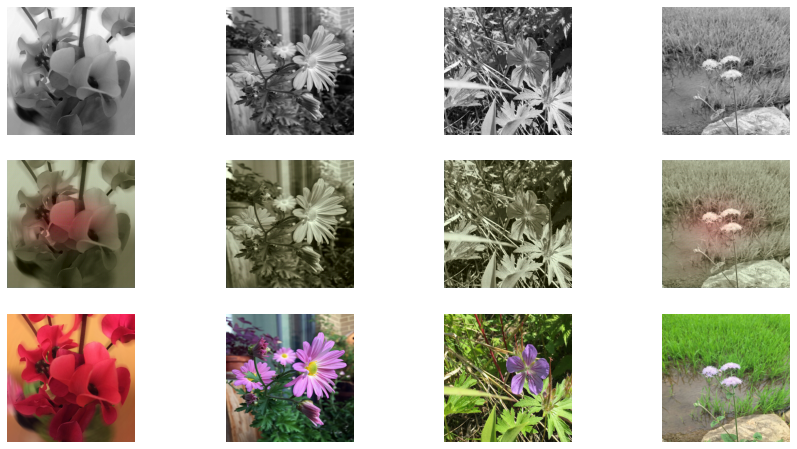

1



2



3



4



5



6



7



8



9



10



11



12



13



14



15



16



17



18



19



20




Epoch 21/50
Iteration 45/45
loss_D_fake: 0.47481
loss_D_real: 0.49739
loss_D: 0.48610
loss_G_GAN: 1.52054
loss_G_L1: 13.95148
loss_G: 15.47202


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 23 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


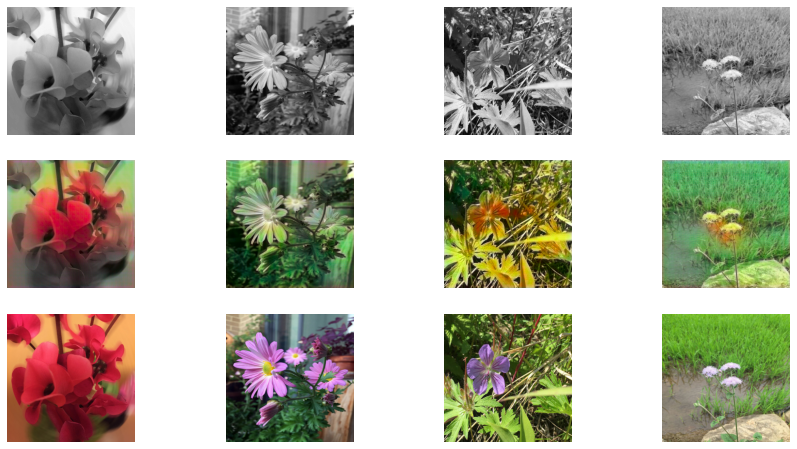

21



22



23



24



25



26



27



28



29



30



31



32



33



34



35



36



37



38



39



40




Epoch 41/50
Iteration 45/45
loss_D_fake: 0.55452
loss_D_real: 0.56598
loss_D: 0.56025
loss_G_GAN: 1.23306
loss_G_L1: 10.72550
loss_G: 11.95857


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 14 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


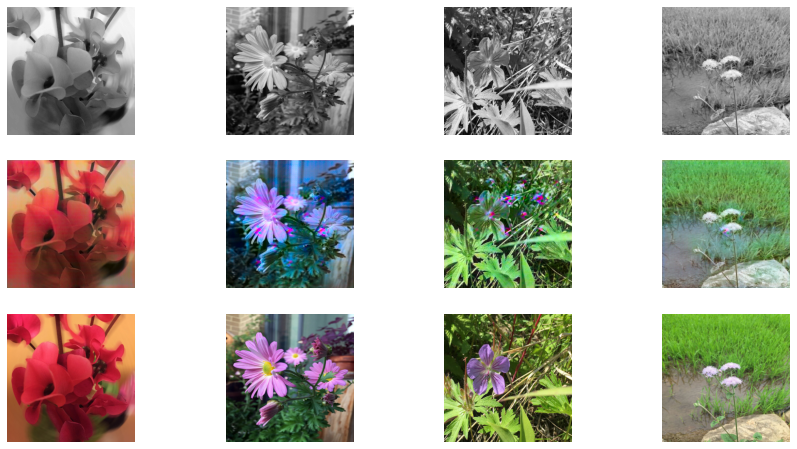

41



42



43



44



45



46



47



48



49


In [ ]:
##

model_x = MainModel()
train_model(model_x,train_dl, 50)

unet test

loss_D_fake: 0.25845
loss_D_real: 0.91097
loss_D: 0.58471
loss_G_GAN: 0.60644
loss_G_L1: 10.15536
loss_G: 10.76180


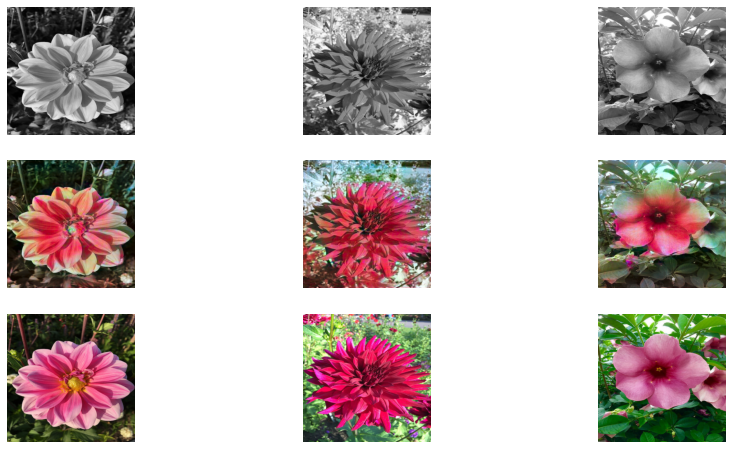

In [ ]:
###
test_model(model_x,test_dl)

Unet+ResNet

In [ ]:
from fastai.vision.learner import create_body
from torchvision.models.resnet import resnet18
from fastai.vision.models.unet import DynamicUnet

In [ ]:
###
def build_res_unet(n_input=1, n_output=2, size=256):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    body = create_body(resnet18, pretrained=True, n_in=n_input, cut=-2)
    net_G = DynamicUnet(body, n_output, (size, size)).to(device)
    return net_G

In [ ]:
###
def pretrain_generator(net_G, train_dl, opt, criterion, epochs):
    for e in range(epochs):
        loss_meter = AverageMeter()
        for data in tqdm(train_dl):
            L, ab = data['L'].to(device), data['ab'].to(device)
            preds = net_G(L)
            loss = criterion(preds, ab)
            opt.zero_grad()
            loss.backward()
            opt.step()
            
            loss_meter.update(loss.item(), L.size(0))
            
        print(f"Epoch {e + 1}/{epochs}")
        print(f"L1 Loss: {loss_meter.avg:.5f}")

net_G = build_res_unet(n_input=1, n_output=2, size=256)
opt = optim.Adam(net_G.parameters(), lr=1e-4)
criterion = nn.L1Loss()        

pretrain model

In [ ]:
###
pretrain_generator(net_G, train_dl, opt, criterion, 20)


Epoch 1/20
L1 Loss: 0.15259



Epoch 2/20
L1 Loss: 0.14148



Epoch 3/20
L1 Loss: 0.13884



Epoch 4/20
L1 Loss: 0.13776



Epoch 5/20
L1 Loss: 0.13788



Epoch 6/20
L1 Loss: 0.13528



Epoch 7/20
L1 Loss: 0.13433



Epoch 8/20
L1 Loss: 0.13280



Epoch 9/20
L1 Loss: 0.12981



Epoch 10/20
L1 Loss: 0.12964



Epoch 11/20
L1 Loss: 0.12667



Epoch 12/20
L1 Loss: 0.12477



Epoch 13/20
L1 Loss: 0.12325



Epoch 14/20
L1 Loss: 0.12182



Epoch 15/20
L1 Loss: 0.12036



Epoch 16/20
L1 Loss: 0.11915



Epoch 17/20
L1 Loss: 0.11722



Epoch 18/20
L1 Loss: 0.11506



Epoch 19/20
L1 Loss: 0.11495



Epoch 20/20
L1 Loss: 0.11258


In [ ]:
###

torch.save(net_G.state_dict(), "res18-unet.pt")

In [ ]:
####

#with
net_G = build_res_unet(n_input=1, n_output=2, size=256)
net_G.load_state_dict(torch.load("res18-unet.pt", map_location=device))
model = MainModel(net_G=net_G)
train_model(model, train_dl, 100)

test unet+resNet pretrain20 train100

loss_D_fake: 0.66373
loss_D_real: 0.61243
loss_D: 0.63808
loss_G_GAN: 0.78081
loss_G_L1: 4.77227
loss_G: 5.55308


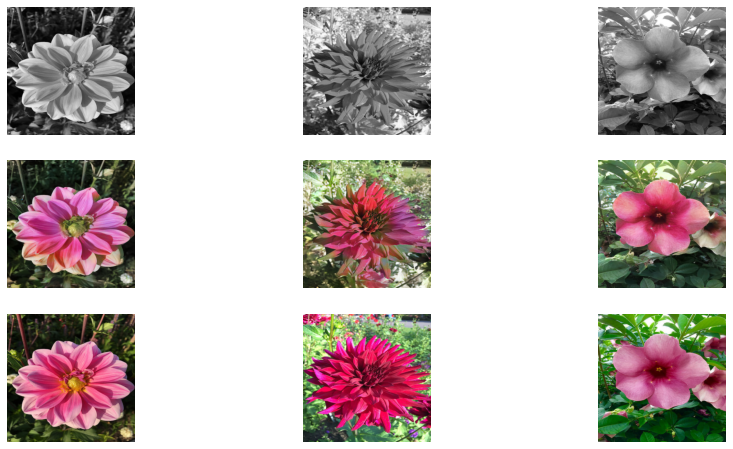

In [ ]:
###

test_model(model,test_dl)

In [ ]:
net_G_2 = build_res_unet(n_input=1, n_output=2, size=256)
opt = optim.Adam(net_G_2.parameters(), lr=1e-4)
criterion = nn.L1Loss()

In [ ]:
model_2 = MainModel(net_G=net_G_2)
train_model(model_2, train_dl, 100)

In [ ]:
test_model(model_2,test_dl)